## <span style=color:blue>In this notebook, we illustrate how to get the NDVI value for a single cell of size roughly 100m x 100m.  This will give you the basic machinery needed to gather sequences of NDVI values that can be incorporated into your ML pipelines   </span>

### <span style=color:blue>First, we create function that retrieves the NVDI for a given year, week, and 100m x 100m cell centered at some lon-lat   </span>

<span style=color:blue>To get started with accessing SentinelHub using Python, I found the site https://sentinelhub-py.readthedocs.io/en/latest/index.html to be helpful.  In particular, you can find and download the SentinelHub-py github repository at https://github.com/sentinel-hub/sentinelhub-py, and then work through some of the Examples.</span>

<span style=color:blue>First, we set up access to SentinelHub</span>

In [7]:
import os

# To access SentinelHub you need a client_id and client_secret.
# To get your own access to SentinelHub, go
#    to https://docs.sentinel-hub.com/api/latest/api/overview/authentication/.
#    From there you can get a user name and password for a free 30-day trial.
#    Once you sign in, find you way to
#    https://apps.sentinel-hub.com/dashboard/, and from the 
#    "User Settings" area you can create an OAuth client -- this will give you 
#    a Client_ID and a Client_Secret.  (I had to create a couple of these in order
#    to get one that worked.  Also, they do expire after a while...)
# I put my client_ID and client_secret into some environment variables

SENTINEL_CLIENT_ID = os.getenv('SENTINEL_CLIENT_ID')
SENTINEL_CLIENT_SECRET = os.environ.get('SENTINEL_CLIENT_SECRET')


<span style=color:blue>Now create a client for accessing SentinelHub     </span>

In [8]:
from sentinelhub import SHConfig

config = SHConfig()

# using third client id and secret, from 2023-05-26
config.sh_client_id = SENTINEL_CLIENT_ID
config.sh_client_secret = SENTINEL_CLIENT_SECRET

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")
else:
    print("Successfully set up SentinelHub client")

Successfully set up SentinelHub client


<span style=color:blue> Not sure why sentinelhub examples include this next cell, but I will blindly imitate them   </span>

In [9]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

<span style=color:blue>Importing useful things from SentinelHub  </span>

In [10]:
import datetime
import os
import sys

import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

# The following is not a package. It is a file utils.py which should be in the same 
#     folder as this notebook.
# As a slight variation, I have cloned the sentinelhub-py repo into my local github, 
#     and grab utils.py from there
sys.path.append('/Users/rick/github/sentinelhub-py/examples/')
from utils import plot_image

### <span style=color:blue>As a small warm-up exercise, to help you get familiar with accessing data from SentinalHub, here is an example of pulling some RGB data and viewing it     </span>

<span style=color:blue> First, identifying a couple of bounding boxes to work with. Note that the second example is focusing on a single cell with size about 100m x 100m. </span>

In [27]:
# convenient site for finding lat/long coordinates:
#     http://bboxfinder.com/#0.000000,0.000000,0.000000,0.000000

# Bounding box containing the 7 soybean states of interest is as follows:
# [-104.370117,35.782171,-79.628906,48.048710]
# However, this is too big of a region to request in one call to SentinelHub

# Bounding box for about 1/8 of Iowa
# [-96.481934,42.520700,-95.075684,43.516689]

corner_iowa_coords_wgs84 = (-96.481934,42.520700,-95.075684,43.516689)

# a central point in IOWA
# [-96.350098,42.195969,-93.801270,43.484812]

# by using corners that are .001 apart, with 100 meter resultion, I get a box with
#    size 1 x 1 pixels
# In contrast, if I am .01 apart, at this location in central Iowa, then I get a box with
#    size 8 x 11 pixels

# The following lon-lat is in Buena Vista county, Iowa, 
# and was a soybean field in 2022 (but apparently not in 2021...)

lon = -94.7386486
lat = 42.6846289

# building a .001 degree x .001 degree bbox around that
point_iowa_wgs84 = (-94.738, 42.684, -94.737, 42.685)
# central_iowa_wgs84 = (-94.73,42.68,--94.74,42.69)

<span style=color:blue>Once you have the bounds for a box, then you can initialize a "BBox" object and specify both its bounds and also the desired resolution.    </span>

<span style=color:blue>Note: by experimenting I found that you cannot request an image where the box has > 2500 pixels along either direction.  Also, each pixel can be at most 200 m x 200 m.  This puts an effective limit on the size of box you can retrieve with one call to SentinelHub -- about 500km x 500km at the equator.   </span>

In [28]:
# using 150m, because when I used 200m the actual request used 203m, 
#     which exceeded the bound on pixel size
resolution1 = 150
corner_iowa_bbox = BBox(bbox=corner_iowa_coords_wgs84, crs=CRS.WGS84)
corner_iowa_size = bbox_to_dimensions(corner_iowa_bbox, resolution=resolution1)

resolution2 = 100
point_iowa_bbox = BBox(bbox=point_iowa_wgs84, crs=CRS.WGS84)
point_iowa_size = bbox_to_dimensions(point_iowa_bbox, resolution=resolution2)


print(f"For corner Iowa box, image shape at {resolution1} m resolution: {corner_iowa_size} pixels")
print()

print(f"For point Iowa box, image shape at {resolution2} m resolution: {point_iowa_size} pixels")

For corner Iowa box, image shape at 150 m resolution: (788, 712) pixels

For point Iowa box, image shape at 100 m resolution: (1, 1) pixels


<span style=color:blue>Getting RGB for corner_iowa_bbox     </span>

<span style=color:blue>Here is some helpful text from the example notebook "process_request.ipynb" that I have been following for this part of my notebook </span>

We build the request according to the API Reference, using the SentinelHubRequest class. Each Process API request also needs an evalscript.

The information that we specify in the SentinelHubRequest object is:

    an evalscript,
    a list of input data collections with time interval,
    a format of the response,
    a bounding box and it's size (size or resolution).

The evalscript in the example is used to select the appropriate bands. We return the RGB (B04, B03, B02) Sentinel-2 L1C bands.

With request_true_color_1_day, the image from Jun 12th 2020 is downloaded. Without any additional parameters in the evalscript, the downloaded data will correspond to reflectance values in UINT8 format (values in 0-255 range).

<span style=color:blue>I am also experimenting with request_true_color_7_day, to see what happens if my interval is multiple days. </span>

In [15]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color_1_day = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2020-06-12", "2020-06-13"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=corner_iowa_bbox,
    size=corner_iowa_size,
    config=config,
)

request_true_color_7_day = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2020-06-12", "2020-06-19"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=corner_iowa_bbox,
    size=corner_iowa_size,
    config=config,
)

<span style=color:blue>Invoking these two functions    </span>

In [16]:
corner_iowa_color_imgs_1_day = request_true_color_1_day.get_data()
corner_iowa_color_imgs_7_day = request_true_color_7_day.get_data()

<span style=color:blue>Exploring the outputs.  It appears that the multi-day gives back the sums of the values for the days that are contributing.    </span>

In [17]:
print(f"Returned data is of type = {type(corner_iowa_color_imgs_1_day)} and length {len(corner_iowa_color_imgs_1_day)}.")
print(f"Single element in the list is of type {type(corner_iowa_color_imgs_1_day[-1])} and has shape {corner_iowa_color_imgs_1_day[-1].shape}")
print()
print(corner_iowa_color_imgs_1_day)


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (712, 788, 3)

[array([[[33, 33, 33],
        [33, 32, 32],
        [41, 36, 35],
        ...,
        [61, 46, 43],
        [35, 31, 33],
        [30, 29, 32]],

       [[15, 25, 25],
        [23, 28, 29],
        [27, 30, 30],
        ...,
        [48, 44, 43],
        [25, 29, 29],
        [33, 33, 34]],

       [[21, 27, 27],
        [30, 30, 31],
        [34, 32, 32],
        ...,
        [38, 36, 36],
        [40, 36, 36],
        [35, 33, 34]],

       ...,

       [[47, 42, 38],
        [11, 15, 19],
        [34, 35, 36],
        ...,
        [24, 26, 28],
        [24, 26, 27],
        [25, 27, 29]],

       [[17, 24, 25],
        [31, 34, 34],
        [16, 24, 25],
        ...,
        [27, 29, 29],
        [22, 25, 27],
        [20, 24, 26]],

       [[26, 29, 29],
        [33, 34, 35],
        [42, 41, 40],
        ...,
        [22, 26, 27],
   

In [18]:
print(f"Returned data is of type = {type(corner_iowa_color_imgs_7_day)} and length {len(corner_iowa_color_imgs_7_day)}.")
print(f"Single element in the list is of type {type(corner_iowa_color_imgs_7_day[-1])} and has shape {corner_iowa_color_imgs_7_day[-1].shape}")
print()
print(corner_iowa_color_imgs_7_day)


Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (712, 788, 3)

[array([[[206, 197, 208],
        [199, 193, 207],
        [200, 200, 213],
        ...,
        [189, 183, 193],
        [189, 183, 193],
        [190, 184, 194]],

       [[212, 201, 211],
        [210, 197, 202],
        [203, 197, 209],
        ...,
        [188, 182, 192],
        [189, 183, 193],
        [190, 184, 194]],

       [[220, 210, 220],
        [218, 207, 213],
        [217, 203, 206],
        ...,
        [188, 182, 192],
        [189, 183, 193],
        [190, 183, 194]],

       ...,

       [[ 86,  85,  90],
        [ 95,  94,  99],
        [ 89,  89,  93],
        ...,
        [ 73,  74,  78],
        [ 72,  75,  79],
        [ 70,  71,  77]],

       [[ 82,  83,  88],
        [ 92,  93,  99],
        [ 88,  88,  94],
        ...,
        [ 71,  73,  77],
        [ 72,  74,  77],
        [ 67,  69,  73]],

       [[ 78, 

<span style=color:blue>To plot first single-day image, we have to  get the values to be between 0 and 1.  In fact, we first scale to (0,1) but then multiply by 3.5 to brighten the picture    </span>

Type of each value in ci_image_1_day: uint8


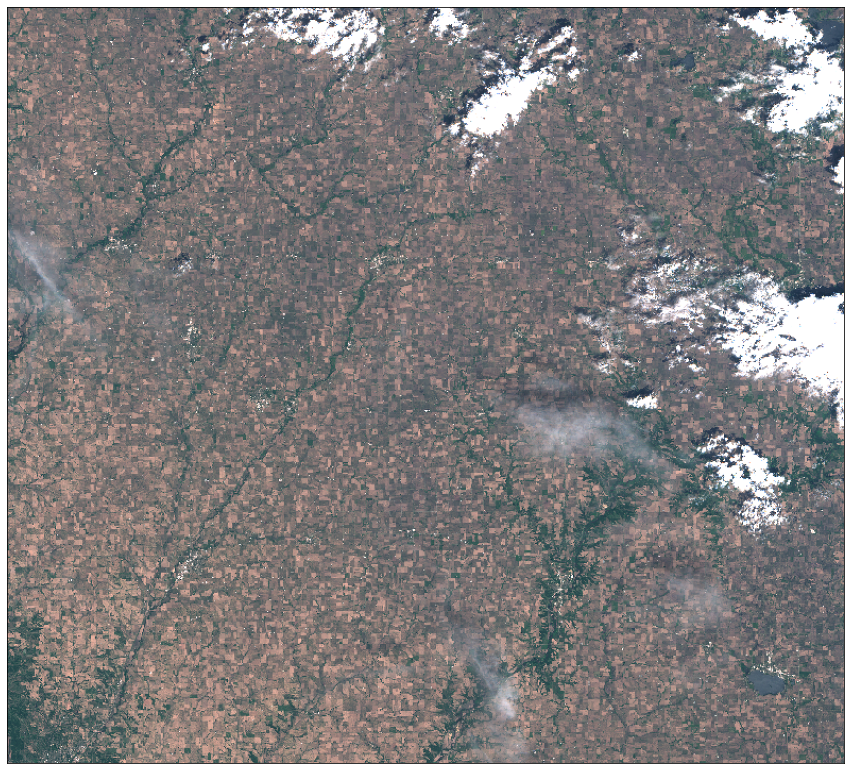

In [20]:
ci_image_1_day = corner_iowa_color_imgs_1_day[0]
print(f"Type of each value in ci_image_1_day: {ci_image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(ci_image_1_day, factor=3.5 / 255, clip_range=(0, 1))

<span style=color:blue>Let's look at how the 7-day interval turns out...   </span>

Type of each value in ci_image_7_day: uint8


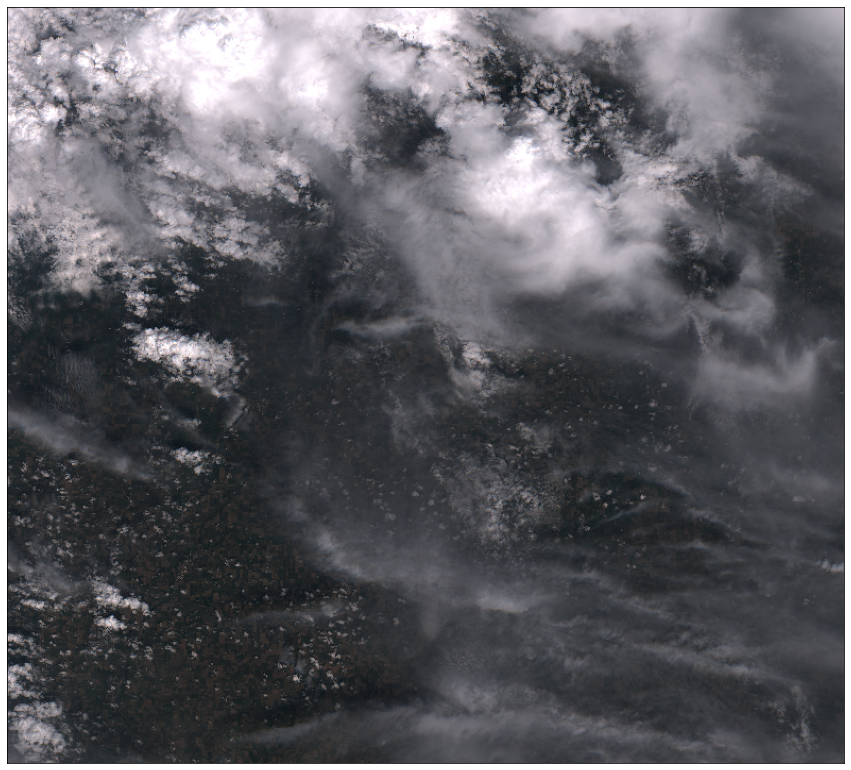

In [26]:
ci_image_7_day = corner_iowa_color_imgs_7_day[0]
print(f"Type of each value in ci_image_7_day: {ci_image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(ci_image_7_day, factor=1 / 255, clip_range=(0, 1))

### <span style=color:blue>Oh my - the clouds are dominating the top part of image!! Please see the example of building cloud masks in the file process_request.ipynb in the Examples area of the sentinelhub-py github repo.    </span>

<span style=color:blue>Building a sentinel request to pull NDVI values for a single 100m x 100m cell.  Recall the formula for NDVI is (B08 - B04) / (B08 + B04).</span>

In [46]:
# Recall that we built point_iowa_bbox (along with point_iowa_size) 
# to be a single pixel of size 100m x 100m, that was in a soybean field in 2022

# It is centered at
lon = -94.7386486
lat = 42.6846289

evalscript_NVDI_bands = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B04", "B08"]
            }],
            output: {
                bands: 2
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B08];
    }
"""

request_NVDI_corner = SentinelHubRequest(
    evalscript=evalscript_NVDI_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2020-06-12", "2020-06-14"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=corner_iowa_bbox,
    size=corner_iowa_size,
    config=config,
)

request_NVDI_point = SentinelHubRequest(
    evalscript=evalscript_NVDI_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2022-08-02", "2022-08-03"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=point_iowa_bbox,
    size=point_iowa_size,
    config=config,
)

print(request_NVDI_point)
data = request_NVDI_point.get_data()
print(data)
print()
B04 = data[0][0][0][0]
B08 = data[0][0][0][1]
print(B04, B08)
NVDI = (B08-B04)/(B08+B04)
print('\nNVDI is: ', NVDI)

print()

# print(request_NVDI_corner)
# print(request_NVDI_corner.get_data())

[array([[[14, 93]]], dtype=uint8)]

14 93

NVDI is:  0.7383177570093458



### <span style=color:blue>Note: if you run the above request on point_iowa_box for "2022-08-01" to "2022-08-02", then you get [0,0].  I think this is because the satellite didn't go over this cell on that one day. Remember that with the two sentinel-2 satellites taken together there is a 5-day return rate. In general, one should probably make single-cell requests that are across a 5 day span, e.g., 2022-04-01 to 2022-04-06. </span>